## Imports

In [1]:
import numpy as np
from numpy import pi, cos, sin, array

In [2]:
from scipy.linalg import toeplitz, inv

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
np.set_printoptions(precision=4, suppress=True)

In [4]:
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

### Useful functions

In [5]:
def calculate_error_rms(x, x_est):
    error = x[:len(x_est)] - x_est
    error_rms = np.linalg.norm(error)/len(error)
    return error_rms.round(5)

## Zero Forcing Equalizer

In [6]:
x = np.random.choice([-1, 1], 40)
channel = array([.1, -.1, 0.05, 1, .05])

y = np.convolve(x, channel)

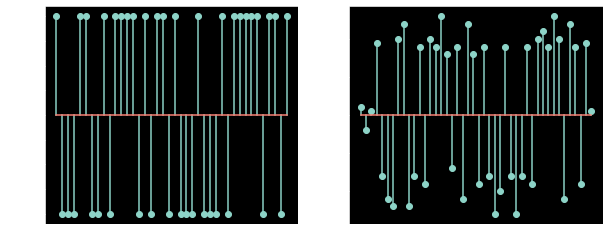

In [7]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].stem(x)
ax[1].stem(y);

In [8]:
# 6 tap equalizer
taps = 6
Y = toeplitz(y[taps-1:taps-1+taps], np.flip(y[:taps]))
zerof = inv(Y)@x[:taps]
zerof

array([ 0.036 , -0.0268,  1.0632, -0.1122,  0.0045,  0.1469])

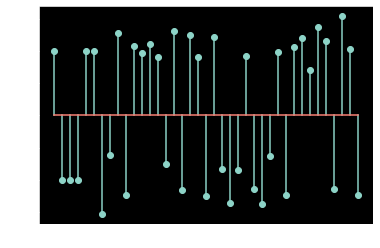

In [9]:
x_zerof = np.convolve(y, zerof, 'valid') # x_est is shorter than x because of 'valid'
plt.stem(x_zerof);

In [10]:
calculate_error_rms(x, x_zerof)

0.03751

## Least Squares Error Equalizer

In [11]:
taps = 6 
L = 30 # number of input samples used
Y = toeplitz(y[taps-1: taps-1+L ] ,np.flip(y[:taps]))
lse = inv(Y.T @ Y)@Y.T @ x[:L]
lse

array([ 0.111 , -0.053 ,  0.9991, -0.0474, -0.0026,  0.0161])

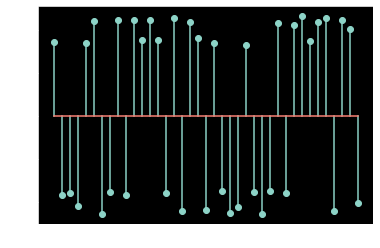

In [12]:
x_lse = np.convolve(y, lse, 'valid')
plt.stem(x_lse);

In [13]:
calculate_error_rms(x, x_lse)

0.01825

### Channel Estimation

In [14]:
L = 30 
taps = 5
X = toeplitz( x[:L], np.zeros(6) )

h_est = inv(X.T@X)@X.T@y[:L]
h_est

array([ 0.1 , -0.1 ,  0.05,  1.  ,  0.05, -0.  ])